In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import time as t
import datetime as dt
import random

from scipy import stats

In [2]:
palette = ['#6D9BC3', '#C0362C', '#E7DD73', '#00937F', '#7B5141',
           '#586BA4', '#B86A84', '#587B7F', '#ABB7C1', '#505050']

custom_params = {
    "figure.figsize": (8, 5), # ширина и высота в дюймах
    "axes.titlesize": 13, # заголовок
    "axes.labelsize": 13, # оси
    "xtick.labelsize": 11, # деления оси X
    "ytick.labelsize": 11, # деления оси Y
    'axes.spines.left': False, # не отображать ось Y
    'axes.spines.right': False, # не отображать правую рамку 
    'axes.spines.top': False, # не отображать верхнюю рамку
}

sns.set_theme(style='ticks', palette=palette, rc=custom_params)

pd.set_option('display.max_rows', 6) # число отображаемых строк по умолчанию (здесь head(3), и tail(3))
pd.set_option('display.max_columns', 20) # число отображаемых столбцов по умолчанию (здесь 20)

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

## 5.2. Комментарий

**Выбор метода** <br>
Формы распределений экспериментальной и контрольной групп заметно отличаются, поэтому t-test скорее всего сработает неэффективно. Для AB-теста будет использоваться пуассоновский бутстреп (размер групп позволяет выбрать этот метод). 

**Нулевая гипотеза:** <br>
Две выборки являются частью единой генеральной совокупности.

**Альтернативная гипотеза:** <br>
Выборки статистически значимо различаются. 

**Результат** <br>
По результатам тестирования с помощью пуассоновского бутстрепа нулевая гипотеза отклоняется - выборки различаются статистически значимо. Контрольная группа в среднем демонстрирует лучшие результаты по CTR. Различия в средних распределяются вокруг 0,01 в форме, схожей с формой нормального распределения, и не пересекают ноль. Если опираться только на результаты теста, то следует отказаться от нового алгоритма.

Но так как форма распределения экспериментальной выборки двухмодальна, можно предположить о влиянии третьей переменной (переменных) на CTR в экспериментальной группе. Чтобы избежать этого в будущем, в ходе АА-теста необходимо проводить проверку значимости не только по CTR, но и по остальным признакам. 

Разделим экспериментальную группу пользователей на две подгруппы - те, у которых CTR меньше или равен среднему и те, у которых CTR больше среднего. <br>
Размер первой подгруппы - 5620, средний CTR равен примерно 0.102, что на 63% ниже, чем у контрольной группы. <br>
Размер второй подгруппы - 4332, средний CTR равен примерно 0.360, что на 67% выше, чем у контрольной группы. <br>
Это означает, что в зависимости от значения условной третьей переменной, с помощью нового алгоритма мы можем либо уменьшить глобальный CTR на 63%, либо увеличить на 67%, что является очень большим приростом. 

В конечном итоге ориентироваться только на результаты тестов было бы неправильно. Необходимо продолжить работу в данном направлении и использовать полученные данные для поиска третьего фактора (факторов), под влиянием которого в экспериментальной группе образовалось две моды. В дальнейшем при необходимости повторить AB-тест, изменив структуру экспериментальной и контрольной группы в зависимости от обнаруженного фактора.

## AB-Test

In [4]:
query = '''
select
    exp_group,
    user_id,
    sum(action='view') as views,
    sum(action='like') as likes,
    likes / views as ctr
from {db}.feed_actions
where toDate(time) between '2022-11-02' and '2022-11-08'
and exp_group in [2,1]
group by exp_group, user_id
'''

In [5]:
df = ph.read_clickhouse(query, connection=connection)

In [6]:
treat_group_num = 2
cont_group_num = 1

In [7]:
df.loc[df['exp_group'] == treat_group_num, 'exp_group'] = 'treatment'
group_treat = df[df['exp_group'] == 'treatment'].copy()

In [8]:
df.loc[df['exp_group'] == cont_group_num, 'exp_group'] = 'control'
group_cont = df[df['exp_group'] == 'control'].copy()

### AB-Test

In [9]:
df

,exp_group,user_id,views,likes,ctr
0,control,109963,15,3,0.200000
1,control,26117,141,32,0.226950
2,control,138232,73,18,0.246575
...,...,...,...,...,...
20028,treatment,25383,127,42,0.330709
20029,treatment,139020,114,24,0.210526
20030,treatment,17310,82,9,0.109756


In [10]:
df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
control,10079,10079,10079,10079
treatment,9952,9952,9952,9952


In [11]:
describe_21 = pd.concat([
    group_treat['ctr'].to_frame().describe().T.rename(index={'ctr': 'ctr_treatment'}),
    group_cont['ctr'].to_frame().describe().T.rename(index={'ctr': 'ctr_control'})],
    axis=0
)

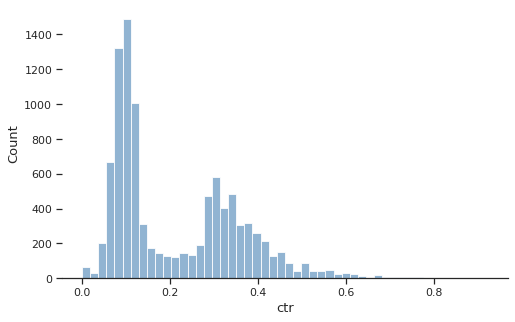

In [12]:
sns.histplot(
    data=df,
    x=group_treat['ctr'],
    bins=50
);

In [13]:
group_treat['ctr'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
ctr,9952.0,0.214419,0.14418,0.0,0.095238,0.142857,0.325,0.923077


In [14]:
# Подгруппа, в которой значение CTR меньше или равно среднему
subgroup1 = group_treat.loc[group_treat['ctr'] <= group_treat['ctr'].mean(), 'ctr']

In [15]:
# Число элементов, у которых значение CTR меньше или равно среднему
subgroup1.count()

5620

In [16]:
# Среднее значение CTR в этой подгруппе
subgroup1.mean()

0.10212540693620031

In [17]:
# Отношение среднего значения CTR этой подгруппы и среднего значения CTR контрольной группы
subgroup1.mean() / group_cont['ctr'].mean()

0.47366989242313023

In [18]:
# Подгруппа, в которой значение CTR больше среднего
subgroup2 = group_treat.loc[group_treat['ctr'] > group_treat['ctr'].mean(), 'ctr']

In [19]:
# Число элементов, у которых значение CTR больше среднего
subgroup2.count()

4332

In [20]:
# Среднее значение CTR в этой подгруппе
subgroup2.mean()

0.3601006054108268

In [21]:
# Отношение среднего значения CTR этой подгруппы и среднего значения CTR контрольной группы
subgroup2.mean() / group_cont['ctr'].mean()

1.6701898199828762

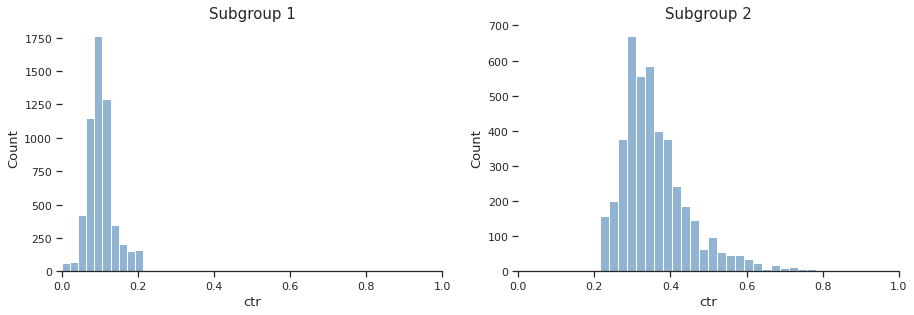

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

plt.subplot(2,2,1)
ax1 = sns.histplot(subgroup1, bins=10)
ax1.set_title('Subgroup 1', fontsize=15)
ax1.set_xlim([0,1])

plt.subplot(2,2,2)
ax2 = sns.histplot(subgroup2, bins=30)
ax2.set_title('Subgroup 2', fontsize=15)
ax2.set_xlim([0,1])

plt.show()

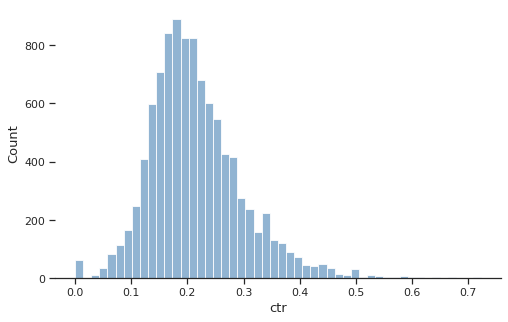

In [23]:
sns.histplot(
    data=df,
    x=group_cont['ctr'],
    bins=50
);

In [24]:
group_cont['ctr'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
ctr,10079.0,0.215605,0.08416,0.0,0.160097,0.203125,0.257654,0.722222


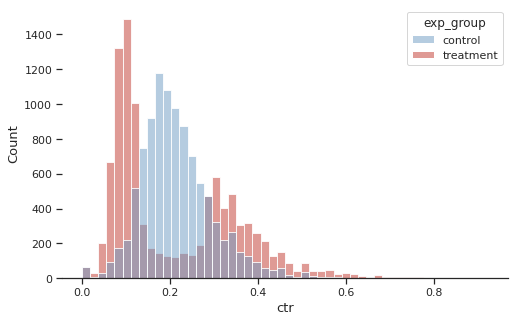

In [25]:
sns.histplot(
    data=df,
    x=df['ctr'],
    hue=df['exp_group'],
    bins=50,
    palette=palette[:2]
);

In [26]:
describe_21

,count,mean,std,min,25%,50%,75%,max
ctr_treatment,9952.0,0.214419,0.14418,0.0,0.095238,0.142857,0.325000,0.923077
ctr_control,10079.0,0.215605,0.08416,0.0,0.160097,0.203125,0.257654,0.722222


### Poisson bootstrap



In [27]:
def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    global_ctr1 = (poisson_bootstraps1*likes1).sum(axis=1)/\
                    (poisson_bootstraps1*views1).sum(axis=1)
    
    global_ctr2 = (poisson_bootstraps2*likes2).sum(axis=1)/\
                    (poisson_bootstraps2*views2).sum(axis=1)

    return global_ctr1, global_ctr2

In [28]:
likes_cont = group_cont['likes'].to_numpy()
views_cont = group_cont['views'].to_numpy()
likes_treat = group_treat['likes'].to_numpy()
views_treat = group_treat['views'].to_numpy()

In [29]:
t_start = t.time()

ctr_treat, ctr_cont = poisson_bootstrap(
    likes_treat, views_treat, 
    likes_cont, views_cont
)

print('Execution time: {}'.format(str(dt.timedelta(seconds=np.round(t.time() - t_start)))), '\n')

Execution time: 0:00:23 



In [30]:
ctr_treat.mean()

0.1980579280931707

In [31]:
ctr_cont.mean()

0.20803094707407768

In [32]:
ctr_diff = ctr_treat - ctr_cont

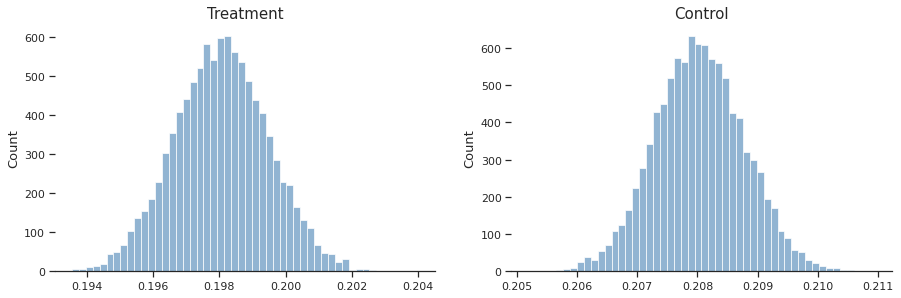

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

plt.subplot(2,2,1)
ax1 = sns.histplot(ctr_treat, bins=50)
ax1.set_title('Treatment', fontsize=15)

plt.subplot(2,2,2)
ax2 = sns.histplot(ctr_cont, bins=50)
ax2.set_title('Control', fontsize=15)

plt.show()

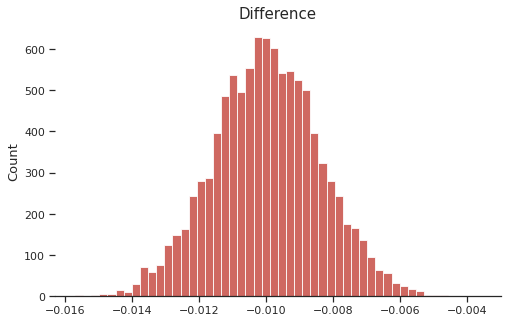

In [34]:
ctr_diff_hist = sns.histplot(ctr_diff, bins=50, color=palette[1])
ctr_diff_hist.set_title('Difference', fontsize=15);

In [35]:
ctr_diff.max()

-0.003583611538591741